In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Deep learning/sc_nlp/

Mounted at /content/drive
/content/drive/MyDrive/Deep learning/sc_nlp


In [ ]:
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.1.1
    Uninstalling accelerate-1.1.1:
      Successfully uninstalled accelerate-1.1.1


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments
from transformers import Trainer
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datasets import DatasetDict

# データの読込
data_df = pd.read_csv("/content/drive/MyDrive/Deep learning/sc_nlp/review_clean_p.csv",encoding='utf-8')
data_df = data_df.drop(columns=data_df.columns[0])
data_df = data_df.rename(columns = { 'text' : 'sentence' }) # 元の文

# データ抽出(train, validation)
train_df = data_df.loc[0:599, ["label","sentence"]].replace("P", 1).replace("N", 0)
validation_df = data_df.loc[600:799, ["label", "sentence"]].replace("P", 1).replace("N", 0)
test_df = data_df.loc[800:999, ["label", "sentence"]].replace("P", 1).replace("N", 0)
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
validation_dataset = Dataset.from_pandas(validation_df)

dataset = DatasetDict({
    "train": train_dataset,
    "validation": validation_dataset,
    "test": test_dataset
})
data_df

<ipython-input-4-3d6813274b4f>:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df = data_df.loc[0:599, ["label","sentence"]].replace("P", 1).replace("N", 0)
<ipython-input-4-3d6813274b4f>:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validation_df = data_df.loc[600:799, ["label", "sentence"]].replace("P", 1).replace("N", 0)
<ipython-input-4-3d6813274b4f>:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_o

,label,sentence
0,N,Ｐ２Ｐは画期的な技術らしいが、どう画期的なのかもう少し作中で教えて欲しかった。作中に入りきら...
1,N,Ｐ２Ｐは画期的な技術らしいが、どう画期的なのかもう少し作中で教えて欲しかった。作中に入りきら...
2,N,ウィニーを作るのが早すぎたのか遅すぎたのか。というセリフがかなり印象的だった。ただ、日本の警...
3,N,興味のない分野だと敬遠していたけど、面白かったな...。地味ですごくよかった。苦手な三浦貴大...
4,N,ファイル共有ソフトを作成した技術者が京都府警に逮捕された出来事を元にした作品。映画の演出もあ...
...,...,...
995,P,神がいない宗教と言っていい。ある種の思想家であるし、新思想を技術者が創出してる時点でフリーメ...
996,P,日本の宝を奪った警察が許せない。この作品が少しでも金子勇さんの慰めになりますように。
997,P,金子さんって本当にこういう方だったんだろうなあと無罪のとこまで見たかった、、、、
998,P,エンジニアとしてのあり方を見た気がした。私も｢山があるから登る｣ようなエンジニアになりたい。...


* 日本語版BERTの形態素解析に使うライブラリをインストール
* fugashi、ipadicは日本語のトークナイザで必要
* トークナイザは入力された文章を細かく分割する機能

In [ ]:
!pip install fugashi
!pip install ipadic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 671.7/671.7 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 69.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556704 sha256=36486886fcf9f1689cd0820dcd9d90e075c0ecf2000485f7aa82c235c1c84463
  Stored in directory: /root/.cache/pip/wheels/5b/ea/e3/2f6e0860a327daba3b030853fce4483ed37468bbf1101c59c3
Successfully built ipadic


更新：WandBを利用するには、アカウント作成が必要　（無料）

https://highreso.jp/edgehub/machinelearning/wandbstartup.html#index_id0

In [ ]:
# 追加unidic-liteをインストール→wandb: Paste an API key from your profile
!pip install unidic-lite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658818 sha256=7ad8ffd186d0a6925b45ec36986f92f8866f75fae9bf3fca3832962ba870263f
  Stored in directory: /root/.cache/pip/wheels/89/e8/68/f9ac36b8cc6c8b3c96888cd57434abed96595d444f42243853
Successfully built unidic-lite


In [ ]:
# トークナイザの取得
tokenizer = AutoTokenizer.from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking")

# モデルの取得
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 2
model = (AutoModelForSequenceClassification
    .from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking", num_labels=num_labels)
    .to(device))

# トークナイザ処理　トークナイザとは文章を語彙（トークン）に分割し、BERTモデルに入力できる形に変換する処理
def tokenize(batch):
    return tokenizer(batch["sentence"], padding=True, truncation=True)
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

# 学習の準備
batch_size = 16
logging_steps = len(dataset_encoded["train"]) // batch_size
model_name = f"classification"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=3,
    learning_rate=2e-5,  #0.00002
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,   #過学習を防ぐためのパラメータの減衰率
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error",
)

# 評価指標の定義
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    #2値分類ならaverage='binary'とする
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# 学習
trainer = Trainer(
    model=model, args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset_encoded["train"],
    eval_dataset=dataset_encoded["validation"],
    tokenizer=tokenizer
)
# Call contiguous() on the model parameters to ensure they are contiguous in memory/モデルパラメータに対してcontiguous()を呼び出し、メモリ内で連続していることを確認
for _, param in model.named_parameters():
    if param.requires_grad:
        param.data = param.data.contiguous()
trainer.train()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/258k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Parameter 'function'=<function tokenize at 0x7c7bf578beb0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-7-96a43c48872d>:49: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.678700,0.474726,0.980000,1.000000,0.980000,0.989899
2,0.623900,0.552377,0.755000,1.000000,0.755000,0.860399
3,0.548900,0.398394,0.920000,1.000000,0.920000,0.958333


TrainOutput(global_step=114, training_loss=0.6148202293797543, metrics={'train_runtime': 123.3458, 'train_samples_per_second': 14.593, 'train_steps_per_second': 0.924, 'total_flos': 122099974128000.0, 'train_loss': 0.6148202293797543, 'epoch': 3.0})

正解率（Accuracy） = 88.50%
適合率（Precision） = 100.00%
再現率（Recall） = 88.50%
F1値（F1-score） = 93.90%


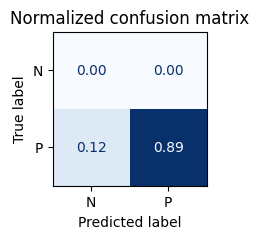

In [ ]:
preds_output = trainer.predict(dataset_encoded["test"])
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(dataset_encoded["test"]["label"])

precision, recall, f1_score, _ = precision_recall_fscore_support(y_valid, y_preds, average="binary")
print('正解率（Accuracy） = {:.2f}%'.format(100 * accuracy_score(y_valid, y_preds))) # 正解率を表示
print('適合率（Precision） = {:.2f}%'.format(100 * precision)) # 適合率を表示
print('再現率（Recall） = {:.2f}%'.format(100 * recall)) # 再現率を表示
print('F1値（F1-score） = {:.2f}%'.format(100 * f1_score)) #F1値を表示

labels = ['N', 'P']
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(2, 2))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_valid,labels)

In [ ]:
preds_df = pd.DataFrame({"predict" : y_preds})
csv_df = pd.concat([data_df.loc[800:999, ].replace("P", 1).replace("N", 0).reset_index(), preds_df], axis = 1)
csv_df["predict"] = csv_df["predict"].replace(1, "P").replace(0, "N")
csv_df["label"] = csv_df["label"].replace(1, "P").replace(0, "N")
csv_df.drop(columns=csv_df.columns[0]).to_csv("/content/drive/MyDrive/Deep learning/sc_nlp/tweets-bert.csv", encoding="utf-8")
#csv_df = csv_df.drop(columns=csv_df.columns[0])
csv_df

<ipython-input-9-dd05977272a9>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  csv_df = pd.concat([data_df.loc[800:999, ].replace("P", 1).replace("N", 0).reset_index(), preds_df], axis = 1)


,index,label,sentence,predict
0,800,P,東出さん、監督、俳優さん皆さんの作品に対する愛情が伝わってきた。とても素晴らしい作品だと思い...,P
1,801,P,ノンフィクションベースのストーリー恥ずかしながらこのwinny事件を知らなくて、、事実関係を...,P
2,802,P,この7年が金子さんの創作活動に充てられてたなら、きっとYouTubeや LINEを越えるモノ...,P
3,803,P,エンジニアの方々が世の中のために、純粋にそして自由に開発を続けることが金子さんが頑張ってくれ...,P
4,804,P,実話なので不謹慎ですが面白い作品でした。金子さんが純粋な技術者なのがすごく伝わってきました。...,P
...,...,...,...,...
195,995,P,神がいない宗教と言っていい。ある種の思想家であるし、新思想を技術者が創出してる時点でフリーメ...,P
196,996,P,日本の宝を奪った警察が許せない。この作品が少しでも金子勇さんの慰めになりますように。,P
197,997,P,金子さんって本当にこういう方だったんだろうなあと無罪のとこまで見たかった、、、、,P
198,998,P,エンジニアとしてのあり方を見た気がした。私も｢山があるから登る｣ようなエンジニアになりたい。...,P
